In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from nltk import word_tokenize, pos_tag, download

download('punkt')
download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sanchez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sanchez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Read in data

In [2]:
path_to_compare_data_1 = "data/UKPConvArg1Strict-CSV/"

files = listdir(path_to_compare_data_1)

all_data = []

for f in files:
    path = path_to_compare_data_1 + f
    one_argument = pd.read_csv(path, sep="\t")
    one_argument["argument_group"] = f
    all_data.append(one_argument)
    
X_raw = pd.concat(all_data).reset_index(drop=True)
X_raw.head()

,#id,label,a1,a2,argument_group
0,arg219237_arg219207,a2,"jesus loves plastic water bottles, and you can...",Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
1,arg219203_arg219206,a2,The American Water companies are Aquafina (Pep...,Americans spend billions on bottled water ever...,ban-plastic-water-bottles_no-bad-for-the-econo...
2,arg219225_arg219284,a1,Banning plastic bottled water would be a huge ...,God created water bottles for a reason. Becaus...,ban-plastic-water-bottles_no-bad-for-the-econo...
3,arg219216_arg219207,a2,The water bottles are a safe source of water a...,Bottled water consumption has grown exponentia...,ban-plastic-water-bottles_no-bad-for-the-econo...
4,arg219207_arg219294,a1,Bottled water consumption has grown exponentia...,"If bottled water did not exist, more people wo...",ban-plastic-water-bottles_no-bad-for-the-econo...


In [3]:
y_raw = X_raw.pop("label")
y_raw.head()

0    a2
1    a2
2    a1
3    a2
4    a1
Name: label, dtype: object

Create base dataset. Make y an integer and rename the arguments to use zero-based indexing.

In [4]:
%%time
y = (y_raw == "a2").astype(int)
X = X_raw.drop(["#id"], axis=1)
X.columns = ["a0", "a1", "argument_group"]

def sentence_tags(text):
#     text = text.decode('utf-8')
    tags = pos_tag(word_tokenize(text))
    only_tags = [t[1] for t in tags]
    return " ".join(only_tags)

X["a0_tags"] = X.a0.apply(sentence_tags)
X["a1_tags"] = X.a1.apply(sentence_tags)

X.head()

Wall time: 1min 23s


In [5]:
y.head()

0    1
1    1
2    0
3    1
4    0
Name: label, dtype: int32

Build a benchmark model as fast as possible.

In [6]:
transition_words = set(['similarly', 'foremost', 'presumably', 'moreover', 'however', 'reason', 'otherwise', 'second,', 'still', 'first', 'even', 'ultimately', 'finally', 'therefore', 'addition', 'next', 'also', 'furthermore', 'conclusion', 'third', 'hand', 'another'])
misspelled_words = set(['wouldn', 'dont', 'shouldn', 'india', 'firefox', 'didn', 'wouldnt', 'doesnt', 'thier', 'farquhar', 'couldn', 'commited', 'adam', 'theyre', 'sabrejimmy', 'persuit', 'definately', 'shouldnt', 'marrage', 'syona', 'alot', 'beleive', 'donot', 'commen', 'especialy', 'dicipline', 'arguement', 'likley', 'lously', 'havn', 'alcohlic', 'wasnt', 'aint', 'bcoz', 'hace', 'decir', 'planta', 'politian', 'acomplice', 'definetly', 'incestual', 'chasbas', 'soooo', 'coolio', 'hoolio', 'infront', 'creatoinism', 'enviroment', 'hasn', 'becasue', 'farquer', 'xada', 'atrever', 'menos', 'dathu', 'ihfej', 'humano', 'charector', 'blimem', 'shld', 'urself', 'tijkjdrk', 'sholud', 'jarman', 'responsibilily', 'preverted', 'plantas', 'aunque', 'sayin', 'xadgeno', 'imformation', 'xbanico', 'sfjiiytg', 'negleted', 'chupar', 'guil', 'xtklp', 'incharge', 'telvisions', 'telivision', 'igual', 'recursos', 'ushould', 'thik', 'supress', 'querido', 'idioma', 'unforms', 'unatrel', 'cauntious', 'evrybdy', 'bookxx', 'beleifs', 'eles', 'completly', 'isnot', 'beleave', 'beter', 'llaman', 'wdout', 'smoken', 'facr', 'illegaly', 'nowadayz', 'doont', 'somkers', 'somke', 'responsiblity', 'homosapien', 'dissappointed', 'criterium', 'hets', 'doughter', 'posible', 'strategizing', 'succeful', 'probaly', 'atleast', 'beileve', 'vida', 'pero', 'mench', 'playstations', 'niega', 'importhant', 'pensar', 'sentir', 'puede', 'aslong', 'ciggarettes', 'sooooooo', 'ebil', 'sito', 'botherd', 'diegnosedca', 'humanos', 'animales', 'suelen', 'aborto', 'matar', 'bullsh', 'employe', 'evryone', 'benifit', 'enviorment', 'lookin', 'persue', 'diffenrent', 'embroyo', 'undertsand', 'interveiw', 'becouse', 'afterschool', 'diferent', 'highschool', 'alreaddy', 'leagal', 'unpetty', 'themselfs', 'yoursel', 'defenceless', 'absolutley', 'peices', 'advencing', 'isnt', 'inequal', 'instinc', 'succesful', 'insctinc', 'disapointment', 'organisation', 'beemed', 'succeded', 'woulld', 'excuss', 'chil', 'singapura', 'majulah', 'mothernature', 'wannna', 'compulsaryy', 'preggo', 'weren', 'dieases', 'relize', 'coloured', 'actualy', 'expirience', 'itll', 'obecity', 'personhood', 'dosent', 'clases', 'mandortory', 'excersise', 'whloe', 'manditory', 'howzz', 'definatley', 'expirence', 'benifits', 'licence', 'echoworld', 'lieing', 'othr', 'alow', 'overal', 'theri', 'stoping', 'selfes', 'becoz', 'mmorning', 'mustn', 'espeacilly', 'perfomed', 'exersises', 'thankyou', 'dreamt', 'theirself', 'cuhz', 'learnt', 'malay', 'proble', 'wether', 'newscientist', 'evealution', 'makind', 'beleivers', 'argumentum', 'populum', 'extreamly', 'callad', 'beleives', 'scientologists', 'aquire', 'existance', 'addons', 'fanboy', 'realeased', 'wayyyyy', 'pointlessss', 'enititys', 'microsot', 'stylesheets', 'google', 'toolbar', 'phro', 'tohttp', 'evol', 'dinosauria', 'neccisary', 'varifiable', 'usgs', 'envirnment', 'nuff', 'polandspring', 'aspx', 'duboard', 'criters', 'worryz', 'excrament', 'produceing', 'evironment', 'poluted', 'healthywater', 'hypocryte', 'friendsjournal', 'garentee', 'compostable', 'youre', 'serval', 'comfortabley', 'suply', 'nikawater', 'nestlewaterscorporate', 'equis', 'ditrabutions', 'treehugger', 'extremly', 'weve', 'aynrandlexicon', 'flipppin', 'belivers', 'religon', 'biggots', 'athieists', 'besause', 'indepent', 'healp', 'lawl', 'sunday', 'spamming', 'therfore', 'recognise', 'simplier', 'didnt', 'xafsm', 'disputs', 'superbrain', 'politians', 'hitech', 'illitrate', 'literated', 'enought', 'specialy', 'fricken', 'opressed', 'illeteracy', 'toughy', 'somone', 'muder', 'marrie', 'sombody', 'accompalice', 'incase', 'hurst', 'basicly', 'preffer', 'nothong', 'tounges', 'contries', 'forgeting', 'ndians', 'hardwork', 'languags', 'utillised', 'prsns', 'ptential', 'manufactoring', 'dependant', 'alawys', 'violance', 'dissapointed', 'tought', 'figuer', 'msitake', 'arent', 'ooooooooh', 'sush', 'differnce', 'wats', 'aryabhatta', 'chatng', 'debatng', 'partical', 'pottential', 'nuissance', 'nalanda', 'jagah', 'achcha', 'hamara', 'britishers', 'orginal', 'americans', 'rama', 'krishna', 'vishvamitr', 'vishvguru', 'francisco', 'nutjobes', 'certainley', 'needn', 'roomates', 'marraige', 'secuality', 'respecful', 'harrassed', 'veiws', 'centry', 'commiting', 'beacuse', 'adware', 'nobrob', 'enuff', 'preinstall', 'derrrr', 'imho', 'weatherfox', 'apps', 'novanet', 'perfrom', 'popup', 'avaible', 'tooltip', 'spaking', 'saame', 'butthole', 'belifs', 'eachother', 'hackman', 'involed', 'throught', 'defence', 'worng', 'couldnt', 'reponsiblity', 'wong', 'woppen', 'nessasary', 'prenup', 'becuase', 'liklihood', 'couse', 'contriverse', 'accomodate', 'extrem', 'pepole', 'accomodations', 'sucied', 'wakoness', 'absoultly'])
slang_words = set(['creep', 'jerk', 'basic', 'wicked', 'diss', 'props', 'unreal', 'dig', 'ripped', 'swole', 'wrecked', 'wasted', 'busted', 'awesome', 'trip', 'cool', 'chilling', 'chill', 'amped', 'blast', 'crush', 'dump', 'geek', 'sick', 'toasted', 'fail', 'epic', 'dunno', 'loser', 'rip', 'off', 'beat', 'bling', 'break', 'cheesy', 'cop', 'out', 'da', 'bomb', 'dope', 'downer', 'fab', 'flake', 'freak', 'disgusting', 'hooked', 'fleet', 'flawless', 'snatched', 'shorty', 'grill', 'hustle', 'grind', 'beef', 'fresh', 'word', 'wack', 'def', 'skeeze', 'ill', 'dough', 'mooch', 'boo', 'baller', 'bromance', 'dawg', 'dude', 'lol', 'ratchet', 'selfie', 'sweet', 'woke', 'neat', 'kidding', 'agame', 'bro', 'cash', 'cop', 'hip', 'jacked', 'hype', 'score', 'trash', 'riled', 'pissed', 'bummer', 'check', 'dead', 'totes'])
important_parts_of_speech = ["vbp", "vbp prp", "nn nn", "to", "dt", "dt nn", "cc"]


def n_general_transitions(x):
    words = x.split()
    total = 0
    for w in words:
        if w in transition_words:
            total += 1
    return total


def n_misspelled_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in misspelled_words:
            total += 1
    return total


def n_slang_words(x):
    words = x.split()
    total = 0
    for w in words:
        if w in slang_words:
            total += 1
    return total

def percent_unique(x):
    words = x.split()
    unique = set(words)
    percent_unique = len(unique)/len(words)
    return percent_unique


class TextBasedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        a0_raw = X.a0
        a1_raw = X.a1
        a0_simple = a0_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a1_simple = a1_raw.str.lower().str.replace("[^a-zA-Z ]", "")
        a0 = a0_simple.str
        a1 = a1_simple.str
        
        # a0 features
        X["characters_a0"] = a0.len()
        X["pronoun_counts_a0"] = a0.count(" you ") + a0.count(" i ") + a0.count(" me ") + a0.count(" my ")
        X["certain_lang_counts_a0"] = a0.count(" always ") + a0.count(" never ") + a0.count(" impossible ")
        X["uncertain_lang_counts_a0"] = a0.count(" believe ") + a0.count(" think ") + a0.count(" feel ")
        X["bold_counts_a0"] = a0_raw.str.count("<br/>")
        X["because_counts_a0"] = a0_raw.str.count("because")
        X["quote_counts_a0"] = a0_raw.str.count("[\"']")
        X["comma_counts_a0"] = a0_raw.str.count(",")
        X["words_a0"] = a0.count(" ") + 1
        X["total_punctuation_a0"] = a0_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a0"] = X["total_punctuation_a0"]/X["characters_a0"]
        X["end_of_sentence_punct_counts_a0"] = a0_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a0"] = (X["end_of_sentence_punct_counts_a0"]==0).astype(int)
        X["sentence_counts_a0"] = X["end_of_sentence_punct_counts_a0"] + X["no_sentence_punctuation_a0"]
        X["average_sentence_word_len_a0"] = X["words_a0"]/X["sentence_counts_a0"]
        X["average_sentence_char_len_a0"] = X["characters_a0"]/X["sentence_counts_a0"]
        X["average_word_length_a0"] = X["characters_a0"]/X["words_a0"]
        X["n_transitions_a0"] = a0_simple.apply(n_general_transitions)
        X["n_misspelled_a0"] = a0_simple.apply(n_misspelled_words)
        X["n_slang_words_a0"] = a0_simple.apply(n_slang_words)
        X["percent_words_unique_a0"] = a0_simple.apply(percent_unique)
        X["first_word_capitalized_a0"] = a0_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a0"] = a0_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a0"] = a0_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a0"] = a0_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["n_links_a0"] = a0_raw.str.count("http")
        X["vbp_a0"] = X.a0_tags.str.count("VBP")
        X["vbp_prp_a0"] = X.a0_tags.str.count("VBP PRP")
        X["nn_nn_a0"] = X.a0_tags.str.count("NN NN")
        X["to_a0"] = X.a0_tags.str.count("TO")
        X["dt_a0"] = X.a0_tags.str.count("DT")
        X["dt_nn_a0"] = X.a0_tags.str.count("DT NN")
        X["cc_a0"] = X.a0_tags.str.count("CC")
        
        # a1 features
        X["characters_a1"] = a1.len()
        X["pronoun_counts_a1"] = a1.count(" you ") + a1.count(" i ") + a1.count(" me ") + a1.count(" my ")
        X["certain_lang_counts_a1"] = a1.count(" always ") + a1.count(" never ") + a1.count(" impossible ")
        X["uncertain_lang_counts_a1"] = a1.count(" believe ") + a1.count(" think ") + a1.count(" feel ")
        X["bold_counts_a1"] = a1_raw.str.count("<br/>")
        X["because_counts_a1"] = a1_raw.str.count("because")
        X["quote_counts_a1"] = a1_raw.str.count("[\"']")
        X["comma_counts_a1"] = a1_raw.str.count(",")
        X["words_a1"] = a1.count(" ") + 1
        X["total_punctuation_a1"] = a1_raw.str.count("[.,?$!:;'\"-]")
        X["punctuation_percent_a1"] = X["total_punctuation_a1"]/X["characters_a1"]
        X["end_of_sentence_punct_counts_a1"] = a1_raw.str.count("[!?.][ \n]")
        X["no_sentence_punctuation_a1"] = (X["end_of_sentence_punct_counts_a1"]==0).astype(int)
        X["sentence_counts_a1"] = X["end_of_sentence_punct_counts_a1"] + X["no_sentence_punctuation_a1"]
        X["average_sentence_word_len_a1"] = X["words_a1"]/X["sentence_counts_a1"]
        X["average_sentence_char_len_a1"] = X["characters_a1"]/X["sentence_counts_a1"]
        X["average_word_length_a1"] = X["characters_a1"]/X["words_a1"]
        X["n_transitions_a1"] = a1_simple.apply(n_general_transitions)
        X["n_misspelled_a1"] = a1_simple.apply(n_misspelled_words)
        X["n_slang_words_a1"] = a1_simple.apply(n_slang_words)
        X["percent_words_unique_a1"] = a1_simple.apply(percent_unique)
        X["first_word_capitalized_a1"] = a1_raw.apply(lambda x: x[0].isupper()*1)
        X["n_proper_nouns_a1"] = a1_raw.str.count("[^.!?;] [A-Z]")
        X["all_caps_words_a1"] = a1_raw.str.count("[A-Z]+[ .!?]")
        X["n_digits_a1"] = a1_raw.apply(lambda x: sum(1 for c in x if c.isdigit()))
        X["n_links_a1"] = a1_raw.str.count("http")
        X["vbp_a1"] = X.a1_tags.str.count("VBP")
        X["vbp_prp_a1"] = X.a1_tags.str.count("VBP PRP")
        X["nn_nn_a1"] = X.a1_tags.str.count("NN NN")
        X["to_a1"] = X.a1_tags.str.count("TO")
        X["dt_a1"] = X.a1_tags.str.count("DT")
        X["dt_nn_a1"] = X.a1_tags.str.count("DT NN")
        X["cc_a1"] = X.a1_tags.str.count("CC")
        
        # diff features
        X["character_diff"] = X["characters_a0"] - X["characters_a1"]
        X["character_diff_percent"] = X["character_diff"]/X["characters_a1"]
        X["pronoun_count_diff"] = X["pronoun_counts_a0"] - X["pronoun_counts_a1"]
        X["certain_language_diff"] = X["certain_lang_counts_a0"] - X["certain_lang_counts_a1"]
        X["uncertain_language_diff"] = X["uncertain_lang_counts_a0"] - X["uncertain_lang_counts_a1"]
        X["bold_counts_diff"] = X["bold_counts_a0"] - X["bold_counts_a1"]
        X["because_counts_diff"] = X["because_counts_a0"] - X["because_counts_a1"]
        X["quote_counts_diff"] = X["quote_counts_a0"] - X["quote_counts_a1"]
        X["comma_counts_diff"] = X["comma_counts_a0"] - X["comma_counts_a1"]
        X["words_diff"] = X["words_a0"] - X["words_a1"]
        X["words_diff_percent"] = X["words_diff"]/X["words_a1"]
        X["punctuation_percent_diff"] = X["punctuation_percent_a0"] - X["punctuation_percent_a1"]
        X["punctuation_percent_diff_percent"] = X["punctuation_percent_diff"]/(X["punctuation_percent_a1"] + 1)
        X["no_sentence_punctuation_diff"] = X["no_sentence_punctuation_a0"] - X["no_sentence_punctuation_a1"]
        X["sentence_diff"] = X["sentence_counts_a0"] - X["sentence_counts_a1"]
        X["average_sentence_word_len_diff"] = X["average_sentence_word_len_a0"] - X["average_sentence_word_len_a1"]
        X["average_sentence_char_len_diff"] = X["average_sentence_char_len_a0"] - X["average_sentence_char_len_a1"]
        X["average_word_length_diff"] = X["average_word_length_a0"] - X["average_word_length_a1"]
        X["average_word_length_diff_percent"] = X["average_word_length_diff"]/X["average_word_length_a1"]
        X["n_transitions_diff"] = X["n_transitions_a0"] - X["n_transitions_a1"]
        X["n_misspelled_diff"] = X["n_misspelled_a0"] - X["n_misspelled_a1"]
        X["n_slang_diff"] = X["n_slang_words_a0"] - X["n_slang_words_a1"]
        X["percent_words_unique_diff"] = X["percent_words_unique_a0"] - X["percent_words_unique_a1"]
        X["first_word_cap_diff"] = X["first_word_capitalized_a0"] - X["first_word_capitalized_a1"]
        X["n_proper_nouns_diff"] = X["n_proper_nouns_a0"] - X["n_proper_nouns_a1"]
        X["all_caps_words_diff"] = X["all_caps_words_a0"] - X["all_caps_words_a1"]
        X["n_digits_diff"] = X["n_digits_a0"] - X["n_digits_a1"]
        X["n_links_diff"] = X["n_links_a0"] - X["n_links_a1"]
        X["vbp_diff"] = X["vbp_a0"] - X["vbp_a1"]
        X["vbp_prp_diff"] = X["vbp_prp_a0"] - X["vbp_prp_a1"]
        X["nn_nn_diff"] = X["nn_nn_a0"] - X["nn_nn_a1"]
        X["to_diff"] = X["to_a0"] - X["to_a1"]
        X["dt_diff"] = X["dt_a0"] - X["dt_a1"]
        X["dt_nn_diff"] = X["dt_nn_a0"] - X["dt_nn_a1"]
        X["cc_diff"] = X["cc_a0"] - X["cc_a1"]       
        return X

    
class KeepNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index.tolist()
        return self
        
    def transform(self, X, y=None):
        return X[self.numeric_columns]

    
class OnlyDiffs(BaseEstimator, TransformerMixin):
    def __init__(self, on=True):
        self.on = on
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.on:
            diff_cols = [c for c in X.columns if "diff" in c]
            other_cols = ["a0_tags", "a1_tags"]
            return X[diff_cols+other_cols]
        else:
            return X
    

class ColNames(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        return X
    
    
def accuracy(y, y_hat, threshold=.5):
    if (len(y_hat.shape) == 2) and (y_hat.shape[1] == 2):
        y_hat = y_hat[:,1]
    return accuracy_score(y, y_hat>threshold)

In [82]:
group_cv = LeaveOneGroupOut()
group_cv.get_n_splits(X, y, X.argument_group)

32

In [83]:
%%time

steps = [("simple_features", TextBasedFeatures()),
         ("only_diff_columns", OnlyDiffs(on=True)),
         ("keep_numeric_only", KeepNumeric()),
         ("col_names", ColNames())]

pipe = Pipeline(steps)

X_clean = pipe.fit_transform(X, y)

Wall time: 1.76 s


In [84]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_predictions = cross_val_predict(rf, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, rf_predictions))

0.798197424893
Wall time: 2min


In [85]:
%%time

scale = StandardScaler()
lr = LogisticRegression(C=0.00125, random_state=42)
lr_pipe = Pipeline([("scale", scale), 
                    ("model", lr)])

lr_predictions = cross_val_predict(lr_pipe, 
                                   X_clean, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_predictions))

0.796480686695
Wall time: 5.74 s


In [86]:
%%time
svc = SVC(probability=True, cache_size=2000, random_state=42)

svc_pipe = Pipeline([("scale", scale), 
                     ("model", svc)])

svc_predictions = cross_val_predict(svc_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, svc_predictions))

0.792446351931
Wall time: 4min 16s


In [87]:
%%time

et = ExtraTreesClassifier(n_estimators=2000,
                            n_jobs=-1,
                            random_state=42)

et_predictions = cross_val_predict(et, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, et_predictions))

0.795879828326
Wall time: 2min 26s


In [88]:
%%time

best_params_from_gridsearch = {
    'learning_rate': 0.05,
    'loss': 'deviance',
    'max_depth': 3,
    'max_features': 1.0,
    'subsample': 0.3}

gb = GradientBoostingClassifier(random_state=42, **best_params_from_gridsearch)

gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.797424892704
Wall time: 11.1 s


In [89]:
%%time

knn = KNeighborsClassifier(n_neighbors=35, n_jobs=-1)
scale_knn = StandardScaler()

knn_pipe = Pipeline([("scale", scale_knn), 
                     ("model", knn)])

knn_predictions = cross_val_predict(knn_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, knn_predictions))

0.778798283262
Wall time: 7.01 s


In [90]:
from sklearn.linear_model import Perceptron

In [91]:
%%time

pt = Perceptron(random_state=42, n_jobs=-1)
scale_pt = StandardScaler()

pt_pipe = Pipeline([("scale", scale_pt), 
                     ("model", pt)])

pt_predictions = cross_val_predict(pt_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict')
print(accuracy(y, pt_predictions))

0.729785407725
Wall time: 5.29 s


In [92]:
from sklearn.neural_network import MLPClassifier

In [96]:
%%time

best_params = {
    'alpha': 0.0001,
    'beta_1': 0.94,
    'hidden_layer_sizes': (10, 6),
    'learning_rate_init': 0.002}

mlp = MLPClassifier(random_state=42, **best_params)

scale_mlp = StandardScaler()

mlp_pipe = Pipeline([("scale", scale_mlp), 
                     ("model", mlp)])

mlp_predictions = cross_val_predict(mlp_pipe, 
                                    X_clean, 
                                    y, 
                                    cv=group_cv, 
                                    groups=X.argument_group, 
                                    n_jobs=-1, 
                                    method='predict_proba')[:,1]
print(accuracy(y, mlp_predictions))

0.791416309013
Wall time: 18 s


Layer one ensemble

In [97]:
X_ens_1 = pd.DataFrame()
X_ens_1["rf"] = rf_predictions
X_ens_1["lr"] = lr_predictions
X_ens_1["svc"] = svc_predictions
X_ens_1["et"] = et_predictions
X_ens_1["gb"] = gb_predictions
X_ens_1["knn"] = knn_predictions
X_ens_1["pt"] = pt_predictions
X_ens_1["mlp"] = mlp_predictions

In [112]:
%%time

lr = LogisticRegression(C=0.00125, random_state=42)

lr_ens_1_predictions = cross_val_predict(lr, 
                                   X_ens_1, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_1_predictions))

0.78669527897
Wall time: 4.84 s


In [113]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_ens_1_predictions = cross_val_predict(rf, X_ens_1, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, rf_ens_1_predictions))

0.798626609442
Wall time: 1min 26s


In [120]:
%%time

et = ExtraTreesClassifier(n_estimators=2000,
                            n_jobs=-1,
                            random_state=42)

et_ens_1_predictions = cross_val_predict(et, X_ens_1, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, et_ens_1_predictions))

0.798369098712
Wall time: 1min 27s


In [121]:
X_ens_1_detailed = pd.concat([X_ens_1, X_clean], axis=1)

In [123]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_ens_1_det_predictions = cross_val_predict(rf, X_ens_1_detailed, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, rf_ens_1_det_predictions))

0.79991416309
Wall time: 2min 41s


In [124]:
%%time

scale = StandardScaler()
lr = LogisticRegression(C=0.00125, random_state=42)
lr_pipe = Pipeline([("scale", scale), 
                    ("model", lr)])

lr_ens_1_det_predictions = cross_val_predict(lr_pipe, 
                                   X_ens_1_detailed, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_1_det_predictions))

0.799055793991
Wall time: 5.94 s


In [125]:
%%time

et = ExtraTreesClassifier(n_estimators=2000,
                            n_jobs=-1,
                            random_state=42)

et_ens_1_det_predictions = cross_val_predict(et, X_ens_1_detailed, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, et_ens_1_det_predictions))

0.800600858369
Wall time: 2min 40s


Ensemble layer 2

In [128]:
X_ens_2 = pd.DataFrame()
X_ens_2["rf2"] = rf_ens_1_predictions
X_ens_2["et2"] = et_ens_1_predictions
X_ens_2["lr2"] = lr_ens_1_predictions
X_ens_2["rf2d"] = rf_ens_1_det_predictions
X_ens_2["et2d"] = et_ens_1_det_predictions
X_ens_2["lr2d"] = lr_ens_1_det_predictions
X_ens_2.head()

,rf2,et2,lr2,rf2d,et2d,lr2d
0,0.968,0.9630,0.787948,0.979,0.9800,0.934257
1,0.784,0.8540,0.755912,0.867,0.9015,0.965618
2,0.044,0.0265,0.322685,0.050,0.0310,0.016381
3,0.964,0.9930,0.783276,0.991,0.9840,0.912362
4,0.056,0.0860,0.345479,0.031,0.0385,0.144167


In [129]:
%%time

rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            random_state=42)

rf_ens_2_predictions = cross_val_predict(rf, X_ens_2, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, rf_ens_2_predictions))

0.791502145923
Wall time: 1min 38s


In [130]:
%%time

et = ExtraTreesClassifier(n_estimators=2000,
                            n_jobs=-1,
                            random_state=42)

et_ens_2_predictions = cross_val_predict(et, X_ens_2, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, et_ens_2_predictions))

0.794248927039
Wall time: 1min 29s


In [211]:
%%time

scale = StandardScaler()
lr = LogisticRegression(C=0.26867, random_state=42)
lr_pipe = Pipeline([("scale", scale), 
                    ("model", lr)])

lr_pipe.fit(X_ens_2, y)


lr_ens_2_predictions = cross_val_predict(lr_pipe, 
                                   X_ens_2, 
                                   y, 
                                   cv=group_cv, 
                                   groups=X.argument_group, 
                                   n_jobs=-1, 
                                   method='predict_proba')[:,1]
print(accuracy(y, lr_ens_2_predictions))

0.803862660944
Wall time: 4.89 s


In [33]:
from sklearn.grid_search import RandomizedSearchCV

C:\Users\Sanchez\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Sanchez\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [206]:
grid.best_params_

{'model__C': 0.26867275841806548}

In [56]:
%%time

gb = GradientBoostingClassifier(n_estimators=175,  subsample=.5,
                                random_state=42)

params = {
    "loss": ["deviance", "exponential"],
    "learning_rate": [.045, .05, .05, .055, .06, .065, .07],
    "n_estimators": [215, 220, 225, 225, 230, 235],
    "max_depth": [3, 4, 5],
    "subsample": [.2, .3, .4, .5, .6, .7, .8, .9],
    "max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0],
    
}

grid = RandomizedSearchCV(gb, params, n_iter=50, scoring="accuracy", n_jobs=-1, refit=False, cv=list(group_cv.split(X_clean, groups=X.argument_group)))

grid.fit(X_clean, y)
# gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

# print(accuracy(y, gb_predictions))

Wall time: 10min 48s


In [ ]:
grid.

In [68]:
pd.DataFrame(grid.grid_scores_).sort_values(["mean_validation_score"], ascending=False)

,parameters,mean_validation_score,cv_validation_scores
38,"{'learning_rate_init': 0.001, 'hidden_layer_si...",0.794335,"[0.854166666667, 0.8975, 0.810397553517, 0.743..."
43,"{'learning_rate_init': 0.001, 'hidden_layer_si...",0.793820,"[0.888888888889, 0.89, 0.810397553517, 0.73180..."
41,"{'learning_rate_init': 0.001, 'hidden_layer_si...",0.793820,"[0.888888888889, 0.89, 0.810397553517, 0.73563..."
4,"{'learning_rate_init': 0.0015, 'hidden_layer_s...",0.793734,"[0.847222222222, 0.8975, 0.819571865443, 0.735..."
31,"{'learning_rate_init': 0.0015, 'hidden_layer_s...",0.793734,"[0.881944444444, 0.89, 0.813455657492, 0.74712..."
33,"{'learning_rate_init': 0.002, 'hidden_layer_si...",0.793391,"[0.864583333333, 0.905, 0.82874617737, 0.74329..."
48,"{'learning_rate_init': 0.001, 'hidden_layer_si...",0.793133,"[0.850694444444, 0.9075, 0.816513761468, 0.747..."
13,"{'learning_rate_init': 0.002, 'hidden_layer_si...",0.792189,"[0.850694444444, 0.89, 0.819571865443, 0.70881..."
9,"{'learning_rate_init': 0.002, 'hidden_layer_si...",0.792103,"[0.892361111111, 0.9025, 0.813455657492, 0.754..."
10,"{'learning_rate_init': 0.001, 'hidden_layer_si...",0.792017,"[0.885416666667, 0.8825, 0.822629969419, 0.735..."


In [207]:
cv_results = pd.DataFrame(pd.DataFrame(grid.grid_scores_).parameters.values.tolist())

In [208]:
cv_results["scores"] = pd.DataFrame(grid.grid_scores_).mean_validation_score

In [209]:
cv_results.head()

,model__C,scores
0,2.725691,0.803348
1,0.868358,0.803348
2,2.214892,0.803348
3,2.996037,0.803262
4,2.834922,0.803262


In [76]:
cv_results.groupby("hidden_layer_sizes")["scores"].mean()

hidden_layer_sizes
(10,)      0.790837
(10, 3)    0.790721
(10, 4)    0.791893
(10, 5)    0.789264
(10, 6)    0.791322
Name: scores, dtype: float64

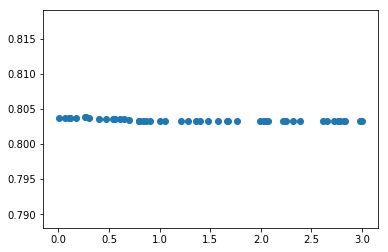

In [210]:
plt.scatter(cv_results.model__C, cv_results.scores)

In [78]:
cv_results.sort_values("scores")

,alpha,beta_1,hidden_layer_sizes,learning_rate_init,scores
37,0.0002,0.96,"(10, 5)",0.0010,0.786524
48,0.0001,0.95,"(10, 5)",0.0010,0.786609
4,0.0001,0.98,"(10, 3)",0.0010,0.787124
6,0.0001,0.98,"(10,)",0.0020,0.787382
8,0.0001,0.94,"(10, 5)",0.0010,0.787639
2,0.0010,0.97,"(10, 5)",0.0010,0.787983
27,0.0001,0.96,"(10, 5)",0.0010,0.788326
21,0.0010,0.95,"(10,)",0.0015,0.788498
43,0.0002,0.95,"(10, 3)",0.0020,0.788584
41,0.0010,0.94,"(10, 6)",0.0015,0.788670


In [79]:
%%time

gb = GradientBoostingClassifier(n_estimators=175,  subsample=.5,
                                random_state=42)

gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.80008583691
Wall time: 18.2 s


In [80]:
%%time

gb = GradientBoostingClassifier(n_estimators=275,  subsample=.4,
                                random_state=42)

gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.796137339056
Wall time: 23.5 s


In [81]:
%%time

gb = GradientBoostingClassifier(n_estimators=275,  subsample=.3,
                                random_state=42)

gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.795793991416
Wall time: 20.7 s


In [75]:
gb = GradientBoostingClassifier(n_estimators=175, subsample=.66,
                                random_state=42)

gb.fit(X_clean, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=175, presort='auto', random_state=42,
              subsample=0.66, verbose=0, warm_start=False)

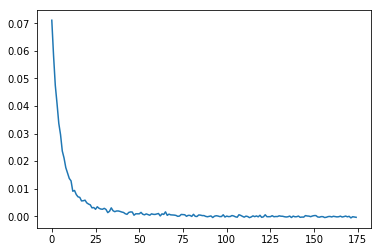

In [77]:
plt.plot(gb.oob_improvement_)

In [72]:
%%time

gb = GradientBoostingClassifier(n_estimators=175,
                                random_state=42)

gb_predictions = cross_val_predict(gb, X_clean, y, cv=group_cv, groups=X.argument_group, n_jobs=-1, method='predict_proba')[:,1]

print(accuracy(y, gb_predictions))

0.799570815451
Wall time: 19.5 s


In [21]:
print("Average: %.4f +/- %.2f" % (scores.mean(), scores.std()*1.96))
print("Scores:", scores)


Average: 0.7988 +/- 0.11
Scores: [ 0.86805556  0.91        0.81651376  0.70881226  0.86797753  0.67370892
  0.83755274  0.83211679  0.79207921  0.84563758  0.85869565  0.80177515
  0.71260997  0.79768786  0.77866667  0.76510067  0.80139373  0.78723404
  0.81341108  0.88157895  0.78587699  0.80182232  0.74670185  0.69491525
  0.69248826  0.81861575  0.81132075  0.81460674  0.77695167  0.79916318
  0.81879195  0.84986595]


In [ ]:
pipe.fit(X, y)

In [ ]:
importances = pipe.named_steps["model"].feature_importances_
columns = pipe.named_steps["col_names"].columns

pd.Series(importances, index=columns).sort_values().plot(kind="barh", figsize=(8,15))

In [82]:
all_words = " ".join(X.a0.unique().tolist())

In [ ]:
imp

In [140]:
temp = X.a0[2]
temp

'Banning plastic bottled water would be a huge mistake in this very moment. More than a million people in the United States purchase bottled water every day which is helping the economy com out of this recession we are in. maybe not in a big way but every kid of help counts! Bottled water also only makes less then 1&#xof; the worlds wastes and can be recycled! According to the National Association for PET Container resources, PET water bottles are no the most recycled container in curb side programs by weight and by number! <br/> http://www.nestlewaterscorporate.com/bottled_water_things_to_know/Video/index.html?@videoList.featured=31101711001'

In [160]:
tags = X.a0_tags.unique()

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [187]:
class TFIDF(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=100):
        self.min_df = min_df
        
    def fit(self, X, y=None):
        tags = X.a0_tags.unique()
        self.tfidf = TfidfVectorizer(ngram_range=(1,15), 
                                     min_df=self.min_df)
        self.tfidf.fit(tags)
        return self
    
    def transform(self, X, y=None):
        a0_vectors = self.tfidf.transform(X.a0_tags).todense()
        a1_vectors = self.tfidf.transform(X.a1_tags).todense()
        diffs = a0_vectors - a1_vectors
        columns = ["tf"+str(i) for i in range(diffs.shape[1])]
        vectors = pd.DataFrame(data=diffs, columns=columns, index=X.index)
        new_data = pd.concat([X, vectors], axis=1)
        return new_data

In [180]:
tf = TfidfVectorizer(ngram_range=(1,15), 
                                  min_df=100)
tf.fit(tags)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=100,
        ngram_range=(1, 15), norm=u'l2', preprocessor=None,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

In [185]:
a0_vectors = tf.transform(X.a0_tags).todense()
a1_vectors = tf.transform(X.a1_tags).todense()
diffs = a0_vectors - a1_vectors

In [ ]:
columns = ["tf"+str(i) for i in range(len(X))]

In [186]:
diffs.shape

(11650, 199)

In [189]:
%%time
tf = TFIDF().fit_transform(X)

CPU times: user 19.7 s, sys: 50 ms, total: 19.8 s
Wall time: 19.8 s


In [ ]:
tf

In [176]:
tfidf.vocabulary_

{u'cc': 0,
 u'cc dt': 1,
 u'cc in': 2,
 u'cc jj': 3,
 u'cc nn': 4,
 u'cc prp': 5,
 u'cc rb': 6,
 u'cc vb': 7,
 u'cd': 8,
 u'dt': 9,
 u'dt jj': 10,
 u'dt jj nn': 11,
 u'dt jj nn in': 12,
 u'dt nn': 13,
 u'dt nn cc': 14,
 u'dt nn in': 15,
 u'dt nn in dt': 16,
 u'dt nn in nn': 17,
 u'dt nn nn': 18,
 u'dt nn prp': 19,
 u'dt nn to': 20,
 u'dt nn vbz': 21,
 u'dt nns': 22,
 u'dt vbz': 23,
 u'ex': 24,
 u'in': 25,
 u'in dt': 26,
 u'in dt jj': 27,
 u'in dt jj nn': 28,
 u'in dt nn': 29,
 u'in dt nn in': 30,
 u'in dt nns': 31,
 u'in in': 32,
 u'in jj': 33,
 u'in jj nn': 34,
 u'in nn': 35,
 u'in nn cc': 36,
 u'in nn in': 37,
 u'in nnp': 38,
 u'in nns': 39,
 u'in prp': 40,
 u'in prp md': 41,
 u'in prp nn': 42,
 u'in prp vbp': 43,
 u'in prp vbz': 44,
 u'in vbg': 45,
 u'jj': 46,
 u'jj cc': 47,
 u'jj in': 48,
 u'jj jj': 49,
 u'jj nn': 50,
 u'jj nn cc': 51,
 u'jj nn in': 52,
 u'jj nn nn': 53,
 u'jj nn prp': 54,
 u'jj nn vbz': 55,
 u'jj nnp': 56,
 u'jj nns': 57,
 u'jj nns in': 58,
 u'jj prp': 59,
 u'jj t

In [ ]:
!pip install nltk

In [10]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sanchez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sanchez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True